### Custom Notebook
This is a custom notebook that modifies the general tutorial in 'alpha.ipynb'. Classes from the module 'gvec' are used, and other operations to manipulate the singles and coincidence structures are explored.

In [1]:
# Setup
import os
import io
import re
import string
import tqdm
import math
import random
import numpy as np

import gvec

# turn off GPU acceleration by default
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/home/dlenz/mambaforge/envs/gammavec/lib/python3.11/site-packages/jaxlib/cuda'

import tensorflow as tf
from tensorflow.keras import layers

import matplotlib
import matplotlib.pyplot as plt

# Load the TensorBoard notebook extension
%load_ext tensorboard

SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

2023-12-16 11:06:55.532672: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-16 11:06:55.561252: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.config.list_physical_devices('GPU'))

[]


2023-12-16 11:06:57.477528: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


#### Construct training sample

Maxes not equal: 800.0 795.0


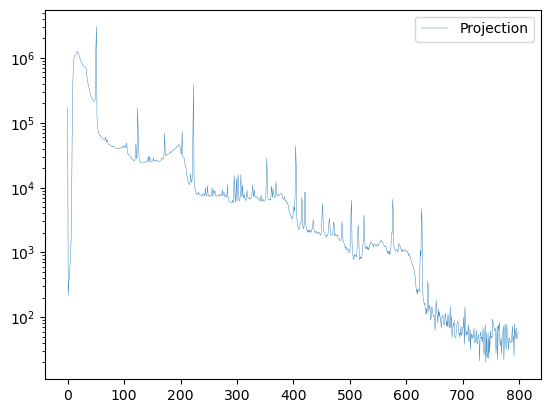

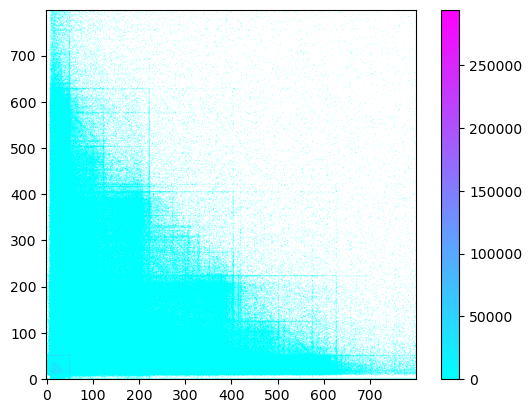

In [3]:
filename = '../data/coincidences_histogram_2D_10keVbins.csv'
dm = gvec.DataManager(filename)

dm.plot1D()
dm.plot2D()

In [4]:
# Create vocabular data structures
hProjection = dm.getProjection()
orderToBin = dm.getSortedVocab()
binToOrder = dm.getBinOrder()

#debug: print first few entries
print(binToOrder[:20])
print(orderToBin[:20])

[ 44 631 621 618 614 595 505 401  55  31  23  12  10   8   7   6   4   2
   3   5]
[51 50 17 18 16 19 15 14 13 20 12 21 11 22 23 24 25 26 27 28]


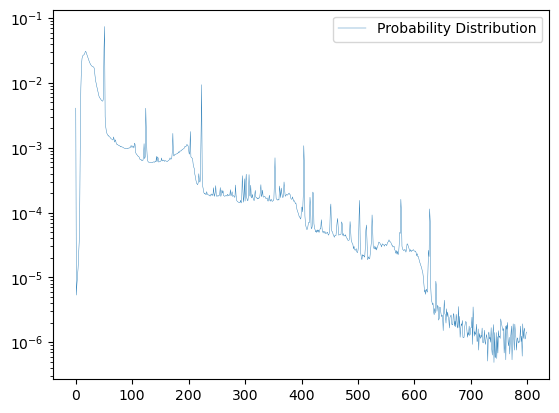

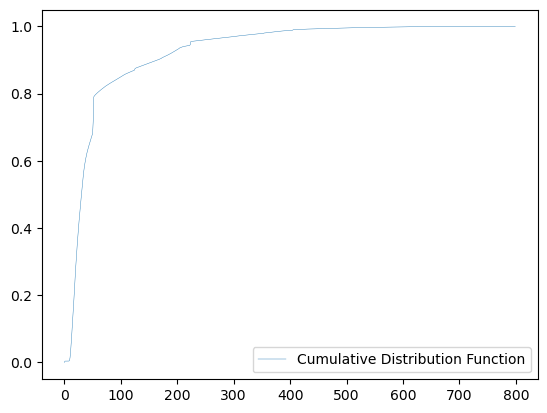

In [6]:
dm.plotPDF()
dm.plotCDF()

In [7]:
# Randomly sample indices from the sorted list using the log-uniform distribution
def sample_random_log_uniform_bin(sorted_list):
    
    # Define the minimum and maximum exponents for the log-uniform distribution
    min_exp = 0
    max_exp = math.log10(sorted_list[-1])
    
    # Generate a random exponent within the defined range
    random_exp = random.uniform(min_exp, max_exp)

    # Calculate the corresponding index in the sorted list
    index = int(10 ** random_exp) - 1

    # Sample the value at the generated index
    sampled_value = sorted_list[index]

    #return sampled_value
    return index

In [10]:
# Generate positive and negative skip-gram examples
nbins = dm.nbins
hCoincidences = dm.hCoincidences
positive_skip_grams = []
negative_skip_grams = []
num_neg_examples=10
vocab_size = nbins

# """
# 'binToOrder' is an array that gives the frequency order of each bin.
# So, binToOrder[i] gives the order of bin i in terms of frequency.

# 'orderToBin' is the opposite of binToOrder. That is,
# if   j = binToOrder[i]
# then i = orderToBin[j]

# In other words, orderToBin[i] gives the bin index for the ith-most 
# frequent bin.
# """

# Loop over all rows of the 2D histogram
for y in range(nbins):
    for x in range(y, nbins):
        count = int(hCoincidences[x,y]/100)
        order1 = binToOrder[x]
        order2 = binToOrder[y]

        # Generate positive example for each instance of coincidence involving x/y bin
        for i in range(count):
            positive_skip_grams.append((order1, order2))
            # Now randomly generate n times as many negative examples
            # for neg in range(num_neg_examples):
            for j in range(num_neg_examples):
                negOrder = sample_random_log_uniform_bin(orderToBin)
                negative_skip_grams.append((order1, negOrder))

            positive_skip_grams.append((order2, order1))
            for j in range(num_neg_examples):
                negOrder = sample_random_log_uniform_bin(orderToBin)
                negative_skip_grams.append((order2, negOrder)) 

In [11]:
def parse_skip_grams(pos, neg):
    targets, contexts, labels = [], [], []

    print(len(pos))
    for i in range(len(pos)):
        if (i % 10000 == 0):
            print(i)
        sg = pos[i]
        target_word = sg[0]
        pos_context = sg[1]
        neg_context_words = []
        for j in range(num_neg_examples):
            neg_sg = neg[i*num_neg_examples + j]
            neg_target = neg_sg[0]
            neg_context = neg_sg[1]
            if (neg_target != target_word):
                print("Target words do not match:", target_word, neg_target)
                
            neg_context_words += [neg_context]
        
        context = tf.concat([tf.constant([pos_context], dtype="int64"), 
                                 tf.constant(neg_context_words, dtype="int64")], 0)
        label = tf.constant([1] + [0]*num_neg_examples, dtype="int64")

        targets.append(target_word)
        contexts.append(context)
        labels.append(label)

    return targets, contexts, labels

In [12]:
targets, contexts, labels = parse_skip_grams(positive_skip_grams, negative_skip_grams)


382912
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000


In [29]:
targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print(f"targets length: {len(targets)}")
print(f"contexts length: {len(contexts)}")
print(f"labels length: {len(labels)}")

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

# print(targets[:15])
# print(*contexts[:15])
# print(labels[:15])

targets length: 382912
contexts length: 382912
labels length: 382912


targets.shape: (382912,)
contexts.shape: (382912, 11)
labels.shape: (382912, 11)


In [30]:
# Configure dataset for performance

# use tf.data.Dataset API for efficient batching of potentially large numbers of training examples.
# After this step, you would have a tf.data.Dataset object
# of (target_word, context_word), (label) elements to train your word2vec model!
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

# Apply `Dataset.cache` and `Dataset.prefetch` to improve performance:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 11), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 11), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 11), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 11), dtype=tf.int64, name=None))>


In [31]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=num_neg_examples+1)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

In [32]:
vocab_size = nbins


In [33]:
# Instatiate word2vec and compile with tf.keras.optimizers.Adam optimizer

embedding_dim = 80
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [34]:
# #define a callback to log training statistics for TensorBoard:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

# Train the model on the `dataset` for some number of epochs:
word2vec.fit(dataset, epochs=40, callbacks=[tensorboard_callback])

Epoch 1/40


2023-09-18 13:25:53.022021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [382912,11]
	 [[{{node Placeholder/_1}}]]
2023-09-18 13:25:53.022290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [382912,11]
	 [[{{node Placeholder/_1}}]]


373/373 [==============================] - 2s 3ms/step - loss: 2.1998 - accuracy: 0.2604
Epoch 2/40
373/373 [==============================] - 1s 3ms/step - loss: 2.2973 - accuracy: 0.1629
Epoch 3/40
373/373 [==============================] - 1s 3ms/step - loss: 2.2036 - accuracy: 0.1788
Epoch 4/40
373/373 [==============================] - 1s 2ms/step - loss: 2.1803 - accuracy: 0.1882
Epoch 5/40
373/373 [==============================] - 1s 3ms/step - loss: 2.1684 - accuracy: 0.1984
Epoch 6/40
373/373 [==============================] - 1s 2ms/step - loss: 2.1607 - accuracy: 0.2066
Epoch 7/40
373/373 [==============================] - 1s 3ms/step - loss: 2.1549 - accuracy: 0.2128
Epoch 8/40
373/373 [==============================] - 1s 2ms/step - loss: 2.1493 - accuracy: 0.2147
Epoch 9/40
373/373 [==============================] - 1s 3ms/step - loss: 2.1415 - accuracy: 0.2178
Epoch 10/40
373/373 [==============================] - 1s 2ms/step - loss: 2.1435 - accuracy: 0.2127
Epoch 11/4

In [26]:
!kill 7240

/bin/bash: line 1: kill: (7240) - No such process


In [19]:
#docs_infra: no_execute
# !kill 7240

%tensorboard --logdir logs --host localhost

# %tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 7240), started 56 days, 2:30:44 ago. (Use '!kill 7240' to kill it.)

In [35]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = orderToBin

In [36]:
out_v = io.open('gamma-vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('gamma-metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
#   if index == 0:
#     continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(str(word) + "\n")
out_v.close()
out_m.close()

In [22]:
print("Most frequent bins:")
print(orderToBin[:20])

Most frequent bins:
[51 50 17 18 16 19 15 14 13 20 12 21 11 22 23 24 25 26 27 28]


In [23]:
mybin = 117
# j = binToOrder[mybin]
# j = 1174
dots = np.zeros((nbins,nbins))
for i in range(nbins):
    for j in range(nbins):
        bi = binToOrder[i]
        bj = binToOrder[j]
        dot = 0
        for k in range(embedding_dim):
            dot += weights[bi][k]*weights[bj][k]
        dots[i,j] = dot
    


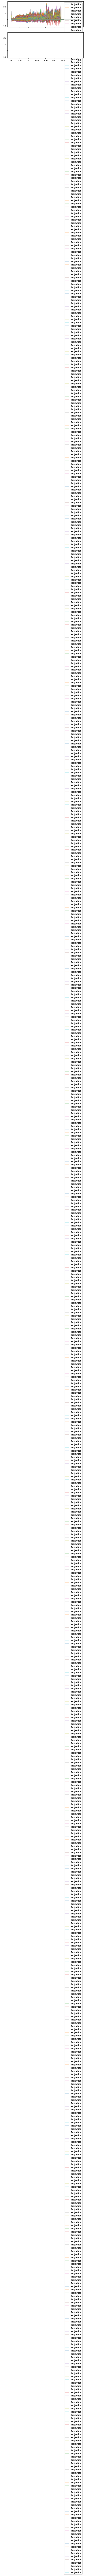

In [24]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, sharey=True)
ax1.plot(dots, linewidth=0.3, label="Projection")
# ax1.semilogy()
ax1.legend()

plt.show()

In [34]:
dot = 0
dist = 0
a = 117
b = 133
for k in range(embedding_dim):
    wa = weights[binToOrder[a]][k]
    wb = weights[binToOrder[b]][k]
    dot += wa*wb
    dist += (wa-wb)**2
    
print("dot prod:", dot)
print("distance:", dist)

dot prod: 1.7513064802624285
distance: 2.4256969515945332


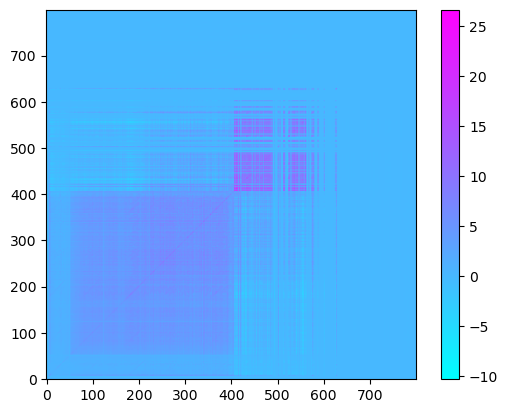

In [37]:
# Subsampling ratio, change as needed
subsample = 1


# n.b. this does not do anything graceful when 'subsample'
#      does not divide evenly into 'nb', but that's probably fine
#      because there is very little data in the highest bin.
nb = dots.shape[0]
nbNew = math.ceil(nb/subsample)
dotsSub = np.zeros((nbNew, nbNew))

# fyi: this loop can take 10-20 seconds
for i in range(nb):
    for j in range(nb):
        isub = int(i/subsample)
        jsub = int(j/subsample)
        dotsSub[isub, jsub] += dots[i, j]

# Create alpha (transparency) channel
# This plots a transparent pixel wherever the bin count is 0
# As a result, it's much easier to see where the nonzero data is
alpha = (dotsSub != 0).astype(float)

# Plot 2D histogram
plt.imshow(dotsSub, origin='lower', alpha=alpha, cmap='cool')
plt.colorbar()
plt.show()